In [216]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
plt.style.use('ggplot')
plt.rc('font', size=15)
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline(connected=True) # 온라인이 아닌 상황에서 처리를 위한 명시 코드

from tqdm import tqdm_notebook

from eunjeon import Mecab

from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim
gensim.__version__  # '3.8.3'

from sklearn.decomposition import PCA

In [217]:
import preprocess_kr

In [340]:
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.options.display.float_format = '{:.2f}'.format

In [219]:
import warnings
warnings.filterwarnings('ignore')

In [220]:
# 전처리된 정제된 파일을 사용한다.
df = pd.read_table('./data/kr_전지적 독자 시점_episode_total_cleaned_list.txt', header =None)

In [221]:
df.columns = ['Review']
df.head()

Review
0                                           전설이 시작된다
1                      전독시 소설은 안봤는데 이거 재밌움 웨툰은 일단 존잼
2                                            나는유중혁이다
3  소설은 완결났길래 이것도 완결 가까워지면 몰아보려고 하는데 지금 전개가 소설 몇화쯤인가요
4                                             정주행가는중

# mecab 토큰화 및 불용어 제거

In [227]:
def get_tokenized_data(df):
    """
    mecab 형태소 분석기를 이용하여 토큰화 및 불용어 제거하는 함수¶
    """
    
    # 불용어 생성
    stopwords = preprocess_kr.make_stop_words()

    # mecab 형태소 분석기 객체 생성 
    mecab = Mecab('C:/mecab/mecab-ko-dic')

    # 결과 리스트
    tokenized_data = []

    # 원래 진행하고자했던 반복문 for i in range(100)에서 'in' 뒤에 문장을 tqdm()으로 감싸주면 진행 상황이 bar로 표현된다.
    # tqdm_notebook 은 tqdm 의 Jupiter Notebook version, progress bar가 예쁘다.
    for sentence in tqdm_notebook(df['Review']):
        tokenized_sentence = mecab.morphs(sentence) # mecab 문장 토큰화

        stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거    
        stopwords_removed_sentence = [word for word in stopwords_removed_sentence if len(word) > 1] # 한글자 제거

        tokenized_data.append(stopwords_removed_sentence)
        
    return tokenized_data

def show_review_info(tokenized_data):
    """
    리뷰 길이 분포 확인 함수
    """
    print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
    print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
    plt.hist([len(review) for review in tokenized_data], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()
    
def get_model_wv(tokenized_data):
    """
    토큰화된 데이터를 Word2Vec 알고리즘을 학습시켜 모델을 반환하는 함수
    """
    # Word2Vec으로 토큰화된 tokenized_data를 학습
    from gensim.models import Word2Vec
    # gensim 4.2 vector_size
    # gensim 3.8.3 size
    model = Word2Vec(sentences = tokenized_data, size = 200, window = 2, min_count = 50, workers = 4, sg = 1)
    
    # embedding_model = Word2Vec(tokenized_contents, size=100, window = 2, min_count=50, workers=4, iter=100, sg=1)
    
    # 포스태깅된 컨텐츠를 100차원의 벡터로 바꿔라. 
    # 주변 단어(window)는 앞뒤로 두개까지 보되, 
    # 코퍼스 내 출현 빈도가 50번 미만인 단어는 분석에서 제외해라. 
    # CPU는 쿼드코어를 쓰고 100번 반복 학습해라. 
    # 분석방법론은 CBOW와 Skip-Gram 중 후자를 선택해라.
    
    # Word2Vec 임베딩 행렬의 크기를 확인
    print("model.wv.vectors.shape: ",model.wv.vectors.shape)
    
    return model    

def print_most_similar_words(model, words_list): 
    """
    특정단어 리스트를 입력받아 유사도를 출력하는 함수
    """
    similar_words = []
    for keyword in words_list:        
        similar_words.append(model.wv.most_similar(keyword))
        print('[', keyword, '] 와 관련있는 단어들 :' , similar_words)
        print()
    return similar_words
        
def get_similarity_btw_two_words(model, w1,w2):
    """
    단어간 유사도 확인 함수
    """
    
    # 모델로부터 단어벡터를 구한다.
    word_vectors = model.wv
    
    vocabs = word_vectors.vocab.keys()
    word_vectors_list = [word_vectors[v] for v in vocabs]

    # 단어간 유사도를 반환
    return word_vectors.similarity(w1, w2)
        
def get_similarity_df(keyword):
    """
    특정 키워드를 입력받아 관련있는 단어를 찾고 유사도를 구하는 함수
    """
    similar_word = model.wv.most_similar(keyword)
    similar_word_df = pd.DataFrame(similar_word)
    similar_word_df.columns=["유사단어","유사도"]
    similar_word_df
    return similar_word_df   

def plot_2d_graph(vocabs, xs, ys):
    """
    단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그리는 함수
    """
    plt.figure(figsize=(10,10))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))    
        
def reduce_dimension_PCA(word_vectors_list):
    """
    PCA를 이용하여 차원을 축소하는 함수
    """
    pca = PCA(n_components=2)
    xys = pca.fit_transform(word_vectors_list[:10])
    xs = xys[:,0]
    ys = xys[:,1]
    return xs, ys        

# 1. 토큰화

In [223]:
tokenized_data = get_tokenized_data(df)
tokenized_data[:10]

stop_words made


  0%|          | 0/276161 [00:00<?, ?it/s]

[['전설', '시작'],
 ['전독시', '소설'],
 ['유중혁'],
 ['소설', '완결', '완결', '가까워', '전개', '소설'],
 ['정주', '행가'],
 ['전독시', '웹툰', '소설', '그림', '별론데', '그림', '체고', '독시', '만들', '함하', '사랑'],
 ['작가', '결말'],
 ['전독시',
  '당하',
  '댓글',
  '들어온',
  '화면',
  '확인',
  '수가',
  '답글',
  '제외',
  '답글',
  '유독',
  '답글',
  '보인다면',
  '내용',
  '차단',
  '도록',
  '개꿀',
  '기억',
  '기분',
  '망치',
  '전체',
  '댓글',
  '구분',
  '으므로',
  '장합'],
 ['김독자', '못생긴', '설정'],
 ['주행', '시작']]

# 2. 댓글 정보 확인

리뷰의 최대 길이 : 250
리뷰의 평균 길이 : 4.295885371214617


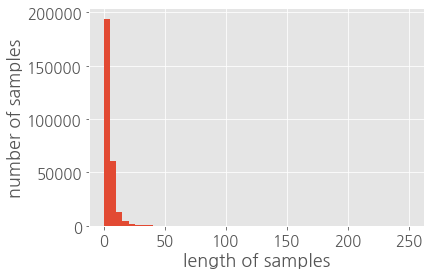

In [224]:
show_review_info(tokenized_data)

# 3. tokenized_data로 모델을 학습

In [225]:
model = get_model_wv(tokenized_data)

model.wv.vectors.shape:  (3084, 200)


In [226]:
# 모델을 저장한다.
model.save('./data/word2vec_kr.model')
 
# 저장한 모델을 읽어온다.
model = Word2Vec.load('./data/word2vec_kr.model')

# 4. 유사단어 검색

In [247]:
words_list = ['독자', '소설', '작가', '그림', '연출', '주인공', '캐릭터', '원작', '작화', '스토리']
topics = print_most_similar_words(model, words_list)
topics

[ 독자 ] 와 관련있는 단어들 : [[('김독자', 0.684213399887085), ('파해', 0.6228017807006836), ('거울', 0.5997833013534546), ('바라보', 0.5857964754104614), ('아니야', 0.5810844898223877), ('위로', 0.5778970718383789), ('초면', 0.5726814866065979), ('고독', 0.565440833568573), ('초점', 0.5642637014389038), ('반했', 0.5628259778022766)]]

[ 소설 ] 와 관련있는 단어들 : [[('김독자', 0.684213399887085), ('파해', 0.6228017807006836), ('거울', 0.5997833013534546), ('바라보', 0.5857964754104614), ('아니야', 0.5810844898223877), ('위로', 0.5778970718383789), ('초면', 0.5726814866065979), ('고독', 0.565440833568573), ('초점', 0.5642637014389038), ('반했', 0.5628259778022766)], [('원작', 0.7500281929969788), ('행중', 0.7360730171203613), ('행하', 0.7190706133842468), ('봤었', 0.6862177848815918), ('잔데', 0.6786385774612427), ('화수', 0.668419599533081), ('봐야겠다', 0.6681879758834839), ('감회', 0.6676291227340698), ('완독', 0.6661131381988525), ('보네', 0.6650048494338989)]]

[ 작가 ] 와 관련있는 단어들 : [[('김독자', 0.684213399887085), ('파해', 0.6228017807006836), ('거울', 0.5997833013534546), (

[[('김독자', 0.684213399887085),
  ('파해', 0.6228017807006836),
  ('거울', 0.5997833013534546),
  ('바라보', 0.5857964754104614),
  ('아니야', 0.5810844898223877),
  ('위로', 0.5778970718383789),
  ('초면', 0.5726814866065979),
  ('고독', 0.565440833568573),
  ('초점', 0.5642637014389038),
  ('반했', 0.5628259778022766)],
 [('원작', 0.7500281929969788),
  ('행중', 0.7360730171203613),
  ('행하', 0.7190706133842468),
  ('봤었', 0.6862177848815918),
  ('잔데', 0.6786385774612427),
  ('화수', 0.668419599533081),
  ('봐야겠다', 0.6681879758834839),
  ('감회', 0.6676291227340698),
  ('완독', 0.6661131381988525),
  ('보네', 0.6650048494338989)],
 [('신가요', 0.6496812701225281),
  ('택배', 0.5916240215301514),
  ('숑님', 0.5902504920959473),
  ('체로', 0.5724693536758423),
  ('만수무강', 0.5709764361381531),
  ('슬리피', 0.5707517266273499),
  ('계신', 0.569233775138855),
  ('수고', 0.5660933256149292),
  ('체도', 0.5613082647323608),
  ('오래오래', 0.5552851557731628)],
 [('작화', 0.7764430046081543),
  ('체가', 0.6911943554878235),
  ('체도', 0.6891821622848511),


In [315]:
topic_list = []
for topic in words_list:
    topic_list.append(topic)
    topic_list.append(topic)
topic_list

['독자',
 '독자',
 '소설',
 '소설',
 '작가',
 '작가',
 '그림',
 '그림',
 '연출',
 '연출',
 '주인공',
 '주인공',
 '캐릭터',
 '캐릭터',
 '원작',
 '원작',
 '작화',
 '작화',
 '스토리',
 '스토리']

In [341]:
df = pd.DataFrame(data=[], 
                  index = ['0','1','2','3','4','5','6','7','8','9'],
                  columns=[ topic_list,  ['topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity','topic','similarity']])  

for index,topic in enumerate(topics): 
    for idx, tup in enumerate(topic):
        word, similarity = tup
        topic_name = words_list[index]
        df[topic_name,'topic'][idx] = word
        df[topic_name,'similarity'][idx] = similarity
df

독자               소설               작가               그림               연출  \
  topic similarity topic similarity topic similarity topic similarity topic   
0   김독자       0.68    원작       0.75   신가요       0.65    작화       0.78    천칭   
1    파해       0.62    행중       0.74    택배       0.59    체가       0.69   연출력   
2    거울       0.60    행하       0.72    숑님       0.59    체도       0.69   이펙트   
3   바라보       0.59    봤었       0.69    체로       0.57    레드       0.68    표현   
4   아니야       0.58    잔데       0.68  만수무강       0.57    신다       0.66    수왕   
5    위로       0.58    화수       0.67   슬리피       0.57    섬세       0.66    투신   
6    초면       0.57  봐야겠다       0.67    계신       0.57   연출력       0.66    재현   
7    고독       0.57    감회       0.67    수고       0.57    예술       0.65    개지   
8    초점       0.56    완독       0.67    체도       0.56    체로       0.65    지린   
9    반했       0.56    보네       0.67  오래오래       0.56    고퀄       0.64    흐르   

                주인공              캐릭터               원작               작화  \
  similarity  topic similarity topic similarity topic similarity topic   
0       0.79     악당       0.67    캐릭       0.79    소설       0.75   퀄리티   
1       0.79     버프       0.62    주연       0.76   아쉬운       0.71    그림   
2       0.78     성격       0.60    매력       0.74  봐야겠다       0.70   연출력   
3       0.75  사이코패스       0.60    조연       0.72   빠져서       0.70    투신   
4       0.74     찌르       0.60    바꾼       0.67    반영       0.70    체도   
5       0.74     패스       0.59    러브       0.66    에바       0.70    오져   
6       0.73     치킨       0.59    악역       0.66    화수       0.69    쳣다   
7       0.73     악역       0.58   반가워       0.65    중후       0.69    퀄이   
8       0.73     남주       0.57    나름       0.65   감정선       0.69    입감   
9       0.73    싸이코       0.57    특이       0.65  아무래도       0.69    채색   

               스토리             
  similarity topic similarity  
0       0.80    느린       0.71  
1       0.78    구성       0.71  
2       0.76    참신       0.70  
3       0.75    흐름       0.70  
4       0.71    깔끔       0.70  
5       0.71   흘러가       0.68  
6       0.70    흥미       0.68  
7       0.70  어마어마       0.67  
8       0.70    전개       0.67  
9       0.70    방대       0.67

# 네트워크 차트

#  5. 단어간 유사도 확인(동작 안 함)

In [156]:
# get_similarity_btw_two_words(model, '김독자 ','한수영')

# 6. 유사단어와 유사도를 데이터프레임으로 확인

In [190]:
words_list

['독자', '소설', '작가', '그림', '연출', '주인공', '캐릭터', '원작', '작화', '스토리']

In [193]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import plotly
import cufflinks as cf
import pandas as pd
import numpy as np

for word in words_list:
    
    similar_word_df = get_similarity_df(word)
    fig = similar_word_df.iplot(kind='pie',labels = "유사단어", 
                                    values="유사도", textinfo="percent+label",
                                    title= word + ' 관련 단어 Top10', hole = 0.5, asFigure=True)
    filename = './data/'+ word + '.html'   
    #plotly.offline.plot(fig,filename=filename)
    fig.show()

# 7. PCA 차원 축소 및 유사도 시각화(동작 안 함)

In [157]:
# xs, ys = reduce_dimension_PCA(word_vectors_list)
# plot_2d_graph(vocabs, xs, ys)